# Phase 5: Manipulation Checks

**Swiss Ballot Chatbot Study - Measurement Analysis**

2x2 Factorial Design: Transparency (T0/T1) x Control (C0/C1)

## Purpose

Verify that the experimental manipulations worked as intended:
- **MC-T** (Perceived Transparency): Did participants in T1 conditions perceive higher transparency than T0?
- **MC-C** (Perceived Control): Did participants in C1 conditions perceive higher control than C0?

| Test | Comparison | Expected Direction |
|------|------------|-------------------|
| MC-T | T0 vs T1 (Perceived transparency) | T1 > T0 |
| MC-C | C0 vs C1 (Perceived control) | C1 > C0 |

## Outputs

For each manipulation check comparison:
- Group descriptives: mean, SD, N for the two groups
- Test result: t (or U), df (if t), p-value
- Effect size: Cohen's d (if t-test) or rank-biserial r (if Mann-Whitney) with 95% CI if available
- Visualization: mean manipulation-check score by group with 95% CI error bars

## Setup & Imports

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Import from Phase 1
from phase1_descriptive_statistics import (
    AnalysisConfig,
    load_participant_data,
    prepare_variables,
    compute_sample_flow
)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')

# Significance threshold
ALPHA = 0.05

print("Setup complete!")

Setup complete!


## Configuration

In [2]:
# Set participant type: 'ai' for AI test users, 'human' for real participants
PARTICIPANT_TYPE = 'human'

config = AnalysisConfig(is_ai_participant=(PARTICIPANT_TYPE == 'ai'))
print(f"Analyzing: {'AI Test Users' if PARTICIPANT_TYPE == 'ai' else 'Human Participants'}")

Analyzing: Human Participants


## Helper Functions

In [3]:
def cohens_d(group1: np.ndarray, group2: np.ndarray) -> tuple:
    """
    Calculate Cohen's d effect size for two independent groups.
    Used when t-test is appropriate (normal data).
    
    Returns: (d, interpretation, ci_lower, ci_upper)
    """
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(ddof=1), group2.var(ddof=1)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    d = (group1.mean() - group2.mean()) / pooled_std if pooled_std > 0 else 0
    
    # Standard error of d (Hedges and Olkin, 1985)
    se_d = np.sqrt((n1 + n2) / (n1 * n2) + (d**2) / (2 * (n1 + n2)))
    
    # 95% CI
    ci_lower = d - 1.96 * se_d
    ci_upper = d + 1.96 * se_d
    
    # Interpretation
    abs_d = abs(d)
    if abs_d < 0.2:
        interpretation = "negligible"
    elif abs_d < 0.5:
        interpretation = "small"
    elif abs_d < 0.8:
        interpretation = "medium"
    else:
        interpretation = "large"
    
    return d, interpretation, ci_lower, ci_upper


def rank_biserial_r(U: float, n1: int, n2: int) -> tuple:
    """
    Calculate rank-biserial correlation from Mann-Whitney U with 95% CI.
    Used when Mann-Whitney U is appropriate (non-normal data).
    
    scipy.mannwhitneyu(x, y) returns U for x: large U means x dominates y.
    r = 2U/(n1*n2) - 1 gives positive r when first group has higher values.
    CI via Fisher z-transformation.
    
    Returns: (r, interpretation, ci_lower, ci_upper)
    """
    r = (2 * U) / (n1 * n2) - 1
    
    # 95% CI via Fisher z-transformation
    r_clamped = np.clip(r, -0.9999, 0.9999)
    z = np.arctanh(r_clamped)
    se_z = 1.0 / np.sqrt(n1 + n2 - 3)
    z_lo = z - 1.96 * se_z
    z_hi = z + 1.96 * se_z
    ci_lower = np.tanh(z_lo)
    ci_upper = np.tanh(z_hi)
    
    # Interpretation
    abs_r = abs(r)
    if abs_r < 0.1:
        interpretation = "negligible"
    elif abs_r < 0.3:
        interpretation = "small"
    elif abs_r < 0.5:
        interpretation = "medium"
    else:
        interpretation = "large"
    
    return r, interpretation, ci_lower, ci_upper


def check_normality(data: np.ndarray, alpha: float = 0.05) -> tuple:
    """
    Check normality using Shapiro-Wilk test.
    
    Returns: (is_normal, W, p)
    """
    if len(data) < 3:
        return False, np.nan, np.nan
    
    # Shapiro-Wilk (works for n < 5000)
    if len(data) <= 5000:
        W, p = stats.shapiro(data)
    else:
        # For larger samples, use random subsample
        subsample = np.random.choice(data, 5000, replace=False)
        W, p = stats.shapiro(subsample)
    
    return p > alpha, W, p


print("Helper functions defined!")

Helper functions defined!


## Load and Prepare Data

In [4]:
# Load data
df_raw = load_participant_data(config)
df = prepare_variables(df_raw, config)

# Apply exclusions
sample_flow = compute_sample_flow(df)
df_filtered = sample_flow['df_filtered']

print(f"\nFinal sample size: N = {len(df_filtered)}")

# Check that manipulation check variables exist
print(f"\nManipulation check variables:")
print(f"  mc_transparency: {'Present' if 'mc_transparency' in df_filtered.columns else 'MISSING'}")
print(f"  mc_control: {'Present' if 'mc_control' in df_filtered.columns else 'MISSING'}")

[INFO] Loaded 291 human participants from participants_human_clean.csv
[INFO] Language codes cleaned: ['de-DE', 'de', 'en-GB', 'en-US', 'en', 'en-CH', 'de-CH', 'fr', 'fr-CH', 'fr-FR', 'en-AU', 'es-ES', 'it', 'gsw'] → ['de', 'en', 'fr', 'other', 'it']
[INFO] Applied language code cleaning for human participants
[INFO] Created derived variables: transparency_level, control_level, T_x_C, mc_transparency, mc_control, out_risk, attention_check_correct, attention_check_missing, attention_check_failed, dashboard fields

PHASE 1.1: SAMPLE FLOW & EXCLUSIONS
Initial N:                           291
Excluded (incomplete survey):         79
Excluded (failed attention):           7
Excluded (missing condition):          0
Excluded (missing donation):           0
------------------------------------------------------------
Final N for analysis:                205

Final sample size: N = 205

Manipulation check variables:
  mc_transparency: Present
  mc_control: Present


## MC-T: Perceived Transparency (T0 vs T1)

In [5]:
print("MANIPULATION CHECK: PERCEIVED TRANSPARENCY (MC-T)")
print("=" * 70)
print("\nExpected: T1 (with Data Nutrition Label) > T0 (without)")

# Get groups
mc_t_t0 = df_filtered[df_filtered['transparency_level'] == 0]['mc_transparency'].dropna().values
mc_t_t1 = df_filtered[df_filtered['transparency_level'] == 1]['mc_transparency'].dropna().values

# Descriptive statistics
print(f"\n--- Descriptive Statistics ---")
print(f"T0 (Low Transparency):  n = {len(mc_t_t0)}, M = {np.mean(mc_t_t0):.2f}, SD = {np.std(mc_t_t0, ddof=1):.2f}")
print(f"T1 (High Transparency): n = {len(mc_t_t1)}, M = {np.mean(mc_t_t1):.2f}, SD = {np.std(mc_t_t1, ddof=1):.2f}")

# Check normality
norm_t0, W_t0, p_t0 = check_normality(mc_t_t0)
norm_t1, W_t1, p_t1 = check_normality(mc_t_t1)

print(f"\n--- Normality Check (Shapiro-Wilk) ---")
print(f"T0: W = {W_t0:.4f}, p = {p_t0:.4f} {'(Normal)' if norm_t0 else '(Non-normal)'}")
print(f"T1: W = {W_t1:.4f}, p = {p_t1:.4f} {'(Normal)' if norm_t1 else '(Non-normal)'}")

use_parametric_t = norm_t0 and norm_t1

# Statistical test + matched effect size
print(f"\n--- Statistical Test ---")
if use_parametric_t:
    t_stat, p_value = stats.ttest_ind(mc_t_t1, mc_t_t0)
    df_t = len(mc_t_t0) + len(mc_t_t1) - 2
    print(f"Test: Independent samples t-test")
    print(f"t({df_t}) = {t_stat:.3f}, p = {p_value:.4f}")
    
    # Effect size: Cohen's d (matches parametric test)
    effect_t, interp_t, ci_lo_t, ci_hi_t = cohens_d(mc_t_t1, mc_t_t0)
    effect_metric_t = "Cohen's d"
    print(f"\nEffect size: Cohen's d = {effect_t:.3f} ({interp_t})")
    print(f"95% CI: [{ci_lo_t:.3f}, {ci_hi_t:.3f}]")
else:
    U, p_value = stats.mannwhitneyu(mc_t_t1, mc_t_t0, alternative='two-sided')
    print(f"Test: Mann-Whitney U (non-parametric)")
    print(f"U = {U:.1f}, p = {p_value:.4f}")
    
    # Effect size: rank-biserial r (matches non-parametric test)
    effect_t, interp_t, ci_lo_t, ci_hi_t = rank_biserial_r(U, len(mc_t_t1), len(mc_t_t0))
    effect_metric_t = "rank-biserial r"
    print(f"\nEffect size: rank-biserial r = {effect_t:.3f} ({interp_t})")
    print(f"95% CI: [{ci_lo_t:.3f}, {ci_hi_t:.3f}]")

# Interpretation
print(f"\n--- Interpretation ---")
manipulation_worked_t = (np.mean(mc_t_t1) > np.mean(mc_t_t0)) and (p_value < ALPHA)
if manipulation_worked_t:
    print(f"✓ MANIPULATION CHECK PASSED")
    print(f"  Participants in T1 conditions perceived significantly higher transparency.")
else:
    if np.mean(mc_t_t1) <= np.mean(mc_t_t0):
        print(f"✗ MANIPULATION CHECK FAILED - Direction wrong")
        print(f"  T1 did not show higher perceived transparency than T0.")
    else:
        print(f"⚠ MANIPULATION CHECK INCONCLUSIVE - Not significant")
        print(f"  Difference in expected direction but p = {p_value:.4f} > α = {ALPHA}")

MANIPULATION CHECK: PERCEIVED TRANSPARENCY (MC-T)

Expected: T1 (with Data Nutrition Label) > T0 (without)

--- Descriptive Statistics ---
T0 (Low Transparency):  n = 95, M = 4.67, SD = 1.24
T1 (High Transparency): n = 110, M = 4.83, SD = 1.09

--- Normality Check (Shapiro-Wilk) ---
T0: W = 0.8716, p = 0.0000 (Non-normal)
T1: W = 0.8746, p = 0.0000 (Non-normal)

--- Statistical Test ---
Test: Mann-Whitney U (non-parametric)
U = 5518.0, p = 0.4801

Effect size: rank-biserial r = 0.056 (negligible)
95% CI: [-0.082, 0.192]

--- Interpretation ---
⚠ MANIPULATION CHECK INCONCLUSIVE - Not significant
  Difference in expected direction but p = 0.4801 > α = 0.05


## MC-C: Perceived Control (C0 vs C1)

In [6]:
print("MANIPULATION CHECK: PERCEIVED CONTROL (MC-C)")
print("=" * 70)
print("\nExpected: C1 (with Granular Dashboard) > C0 (without)")

# Get groups
mc_c_c0 = df_filtered[df_filtered['control_level'] == 0]['mc_control'].dropna().values
mc_c_c1 = df_filtered[df_filtered['control_level'] == 1]['mc_control'].dropna().values

# Descriptive statistics
print(f"\n--- Descriptive Statistics ---")
print(f"C0 (Low Control):  n = {len(mc_c_c0)}, M = {np.mean(mc_c_c0):.2f}, SD = {np.std(mc_c_c0, ddof=1):.2f}")
print(f"C1 (High Control): n = {len(mc_c_c1)}, M = {np.mean(mc_c_c1):.2f}, SD = {np.std(mc_c_c1, ddof=1):.2f}")

# Check normality
norm_c0, W_c0, p_c0 = check_normality(mc_c_c0)
norm_c1, W_c1, p_c1 = check_normality(mc_c_c1)

print(f"\n--- Normality Check (Shapiro-Wilk) ---")
print(f"C0: W = {W_c0:.4f}, p = {p_c0:.4f} {'(Normal)' if norm_c0 else '(Non-normal)'}")
print(f"C1: W = {W_c1:.4f}, p = {p_c1:.4f} {'(Normal)' if norm_c1 else '(Non-normal)'}")

use_parametric_c = norm_c0 and norm_c1

# Statistical test + matched effect size
print(f"\n--- Statistical Test ---")
if use_parametric_c:
    t_stat_c, p_value_c = stats.ttest_ind(mc_c_c1, mc_c_c0)
    df_c = len(mc_c_c0) + len(mc_c_c1) - 2
    print(f"Test: Independent samples t-test")
    print(f"t({df_c}) = {t_stat_c:.3f}, p = {p_value_c:.4f}")
    
    # Effect size: Cohen's d (matches parametric test)
    effect_c, interp_c, ci_lo_c, ci_hi_c = cohens_d(mc_c_c1, mc_c_c0)
    effect_metric_c = "Cohen's d"
    print(f"\nEffect size: Cohen's d = {effect_c:.3f} ({interp_c})")
    print(f"95% CI: [{ci_lo_c:.3f}, {ci_hi_c:.3f}]")
else:
    U_c, p_value_c = stats.mannwhitneyu(mc_c_c1, mc_c_c0, alternative='two-sided')
    print(f"Test: Mann-Whitney U (non-parametric)")
    print(f"U = {U_c:.1f}, p = {p_value_c:.4f}")
    
    # Effect size: rank-biserial r (matches non-parametric test)
    effect_c, interp_c, ci_lo_c, ci_hi_c = rank_biserial_r(U_c, len(mc_c_c1), len(mc_c_c0))
    effect_metric_c = "rank-biserial r"
    print(f"\nEffect size: rank-biserial r = {effect_c:.3f} ({interp_c})")
    print(f"95% CI: [{ci_lo_c:.3f}, {ci_hi_c:.3f}]")

# Interpretation
print(f"\n--- Interpretation ---")
manipulation_worked_c = (np.mean(mc_c_c1) > np.mean(mc_c_c0)) and (p_value_c < ALPHA)
if manipulation_worked_c:
    print(f"✓ MANIPULATION CHECK PASSED")
    print(f"  Participants in C1 conditions perceived significantly higher control.")
else:
    if np.mean(mc_c_c1) <= np.mean(mc_c_c0):
        print(f"✗ MANIPULATION CHECK FAILED - Direction wrong")
        print(f"  C1 did not show higher perceived control than C0.")
    else:
        print(f"⚠ MANIPULATION CHECK INCONCLUSIVE - Not significant")
        print(f"  Difference in expected direction but p = {p_value_c:.4f} > α = {ALPHA}")

MANIPULATION CHECK: PERCEIVED CONTROL (MC-C)

Expected: C1 (with Granular Dashboard) > C0 (without)

--- Descriptive Statistics ---
C0 (Low Control):  n = 103, M = 4.35, SD = 1.34
C1 (High Control): n = 102, M = 4.84, SD = 0.95

--- Normality Check (Shapiro-Wilk) ---
C0: W = 0.9258, p = 0.0000 (Non-normal)
C1: W = 0.8926, p = 0.0000 (Non-normal)

--- Statistical Test ---
Test: Mann-Whitney U (non-parametric)
U = 6325.0, p = 0.0104

Effect size: rank-biserial r = 0.204 (small)
95% CI: [0.069, 0.332]

--- Interpretation ---
✓ MANIPULATION CHECK PASSED
  Participants in C1 conditions perceived significantly higher control.


## Manipulation Checks by Condition

In [7]:
# Summary by condition
print("MANIPULATION CHECK SCORES BY CONDITION")
print("=" * 70)

mc_by_condition = df_filtered.groupby('condition').agg({
    'mc_transparency': ['count', 'mean', 'std'],
    'mc_control': ['count', 'mean', 'std']
}).round(2)

mc_by_condition.columns = ['MC-T n', 'MC-T Mean', 'MC-T SD', 'MC-C n', 'MC-C Mean', 'MC-C SD']
mc_by_condition

MANIPULATION CHECK SCORES BY CONDITION


,MC-T n,MC-T Mean,MC-T SD,MC-C n,MC-C Mean,MC-C SD
condition,,,,,,
A,50,4.46,1.39,50,4.39,1.39
B,53,4.74,1.25,53,4.32,1.30
C,45,4.90,1.01,45,4.82,0.91
D,57,4.92,0.92,57,4.86,0.98


## Visualizations

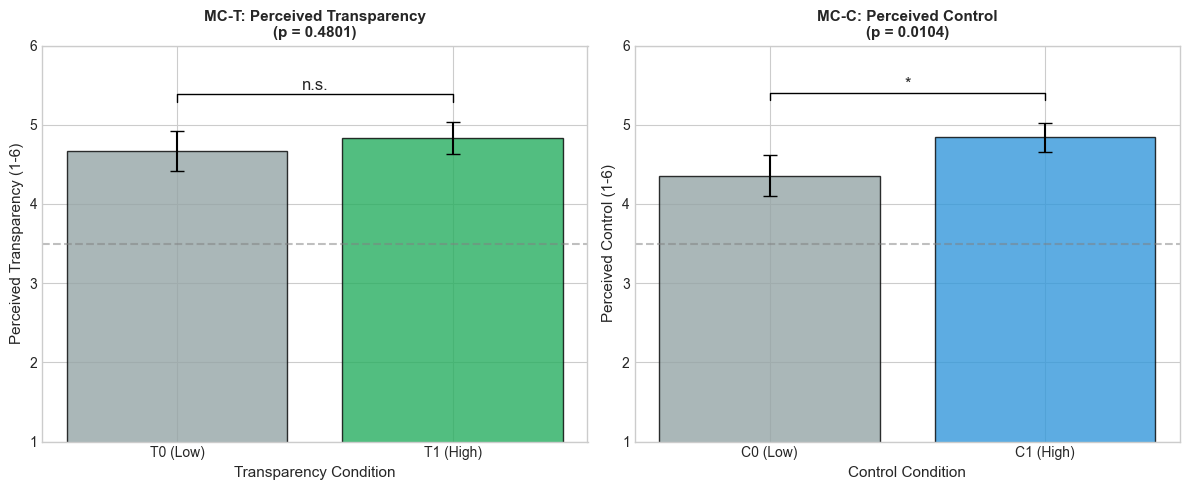

In [8]:
# Figure 1: MC-T by Transparency Level
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Perceived Transparency
ax1 = axes[0]
means_t = [np.mean(mc_t_t0), np.mean(mc_t_t1)]
sems_t = [stats.sem(mc_t_t0), stats.sem(mc_t_t1)]
colors_t = ['#95a5a6', '#27ae60']

bars1 = ax1.bar(['T0 (Low)', 'T1 (High)'], means_t, yerr=[s*1.96 for s in sems_t],
               color=colors_t, edgecolor='black', capsize=5, alpha=0.8)
ax1.set_ylabel('Perceived Transparency (1-6)', fontsize=11)
ax1.set_xlabel('Transparency Condition', fontsize=11)
ax1.set_ylim(1, 6)
ax1.axhline(y=3.5, color='gray', linestyle='--', alpha=0.5, label='Scale midpoint')

# Add significance annotation
if p_value < 0.001:
    sig_text = '***'
elif p_value < 0.01:
    sig_text = '**'
elif p_value < 0.05:
    sig_text = '*'
else:
    sig_text = 'n.s.'

y_max = max(means_t) + max(sems_t)*2 + 0.3
ax1.plot([0, 0, 1, 1], [y_max-0.1, y_max, y_max, y_max-0.1], 'k-', linewidth=1)
ax1.text(0.5, y_max + 0.05, sig_text, ha='center', fontsize=12)

ax1.set_title(f'MC-T: Perceived Transparency\n(p = {p_value:.4f})', fontsize=11, fontweight='bold')

# Right: Perceived Control
ax2 = axes[1]
means_c = [np.mean(mc_c_c0), np.mean(mc_c_c1)]
sems_c = [stats.sem(mc_c_c0), stats.sem(mc_c_c1)]
colors_c = ['#95a5a6', '#3498db']

bars2 = ax2.bar(['C0 (Low)', 'C1 (High)'], means_c, yerr=[s*1.96 for s in sems_c],
               color=colors_c, edgecolor='black', capsize=5, alpha=0.8)
ax2.set_ylabel('Perceived Control (1-6)', fontsize=11)
ax2.set_xlabel('Control Condition', fontsize=11)
ax2.set_ylim(1, 6)
ax2.axhline(y=3.5, color='gray', linestyle='--', alpha=0.5, label='Scale midpoint')

# Add significance annotation
if p_value_c < 0.001:
    sig_text_c = '***'
elif p_value_c < 0.01:
    sig_text_c = '**'
elif p_value_c < 0.05:
    sig_text_c = '*'
else:
    sig_text_c = 'n.s.'

y_max_c = max(means_c) + max(sems_c)*2 + 0.3
ax2.plot([0, 0, 1, 1], [y_max_c-0.1, y_max_c, y_max_c, y_max_c-0.1], 'k-', linewidth=1)
ax2.text(0.5, y_max_c + 0.05, sig_text_c, ha='center', fontsize=12)

ax2.set_title(f'MC-C: Perceived Control\n(p = {p_value_c:.4f})', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

/var/folders/m2/wwp0kh353wlcxjqhp1nyx4xm0000gn/T/ipykernel_41679/3869465980.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(data_mc_t, labels=['A\n(T0C0)', 'B\n(T1C0)', 'C\n(T0C1)', 'D\n(T1C1)'],
/var/folders/m2/wwp0kh353wlcxjqhp1nyx4xm0000gn/T/ipykernel_41679/3869465980.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot(data_mc_c, labels=['A\n(T0C0)', 'B\n(T1C0)', 'C\n(T0C1)', 'D\n(T1C1)'],


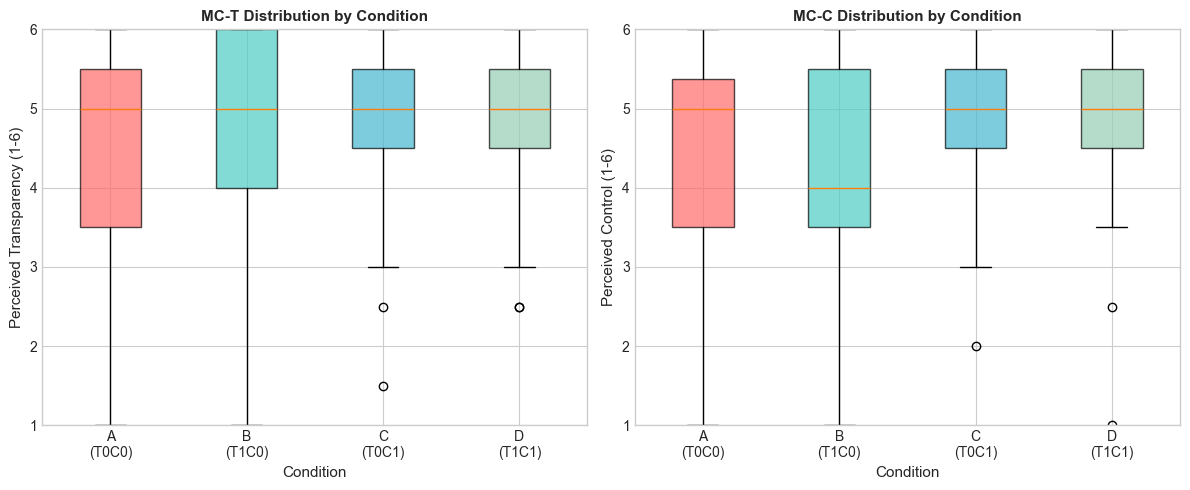

In [9]:
# Figure 2: Box plots by condition
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: MC-T by condition
ax1 = axes[0]
conditions_order = ['A', 'B', 'C', 'D']
colors_cond = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

data_mc_t = [df_filtered[df_filtered['condition'] == c]['mc_transparency'].dropna().values 
             for c in conditions_order]

bp1 = ax1.boxplot(data_mc_t, labels=['A\n(T0C0)', 'B\n(T1C0)', 'C\n(T0C1)', 'D\n(T1C1)'],
                  patch_artist=True)
for patch, color in zip(bp1['boxes'], colors_cond):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_ylabel('Perceived Transparency (1-6)', fontsize=11)
ax1.set_xlabel('Condition', fontsize=11)
ax1.set_ylim(1, 6)
ax1.set_title('MC-T Distribution by Condition', fontsize=11, fontweight='bold')

# Right: MC-C by condition
ax2 = axes[1]
data_mc_c = [df_filtered[df_filtered['condition'] == c]['mc_control'].dropna().values 
             for c in conditions_order]

bp2 = ax2.boxplot(data_mc_c, labels=['A\n(T0C0)', 'B\n(T1C0)', 'C\n(T0C1)', 'D\n(T1C1)'],
                  patch_artist=True)
for patch, color in zip(bp2['boxes'], colors_cond):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_ylabel('Perceived Control (1-6)', fontsize=11)
ax2.set_xlabel('Condition', fontsize=11)
ax2.set_ylim(1, 6)
ax2.set_title('MC-C Distribution by Condition', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## Save Results

In [10]:
# Create output directory
output_dir = './output/phase5'
os.makedirs(output_dir, exist_ok=True)

# Create summary dataframe
mc_summary = pd.DataFrame([
    {
        'Check': 'MC-T (Perceived Transparency)',
        'Low Group': 'T0',
        'High Group': 'T1',
        'n_Low': len(mc_t_t0),
        'n_High': len(mc_t_t1),
        'Mean_Low': round(np.mean(mc_t_t0), 2),
        'Mean_High': round(np.mean(mc_t_t1), 2),
        'SD_Low': round(np.std(mc_t_t0, ddof=1), 2),
        'SD_High': round(np.std(mc_t_t1, ddof=1), 2),
        'Test': 't-test' if use_parametric_t else 'Mann-Whitney U',
        'p_value': round(p_value, 4),
        'Effect_Metric': effect_metric_t,
        'Effect_Size': round(effect_t, 3),
        'Effect_CI_Lower': round(ci_lo_t, 3),
        'Effect_CI_Upper': round(ci_hi_t, 3),
        'Passed': 'Yes' if manipulation_worked_t else 'No'
    },
    {
        'Check': 'MC-C (Perceived Control)',
        'Low Group': 'C0',
        'High Group': 'C1',
        'n_Low': len(mc_c_c0),
        'n_High': len(mc_c_c1),
        'Mean_Low': round(np.mean(mc_c_c0), 2),
        'Mean_High': round(np.mean(mc_c_c1), 2),
        'SD_Low': round(np.std(mc_c_c0, ddof=1), 2),
        'SD_High': round(np.std(mc_c_c1, ddof=1), 2),
        'Test': 't-test' if use_parametric_c else 'Mann-Whitney U',
        'p_value': round(p_value_c, 4),
        'Effect_Metric': effect_metric_c,
        'Effect_Size': round(effect_c, 3),
        'Effect_CI_Lower': round(ci_lo_c, 3),
        'Effect_CI_Upper': round(ci_hi_c, 3),
        'Passed': 'Yes' if manipulation_worked_c else 'No'
    }
])

mc_summary.to_csv(f'{output_dir}/phase5_manipulation_checks_{PARTICIPANT_TYPE}.csv', index=False)
mc_by_condition.to_csv(f'{output_dir}/phase5_mc_by_condition_{PARTICIPANT_TYPE}.csv')

print(f"Results saved to {output_dir}/")

Results saved to ./output/phase5/


In [11]:
# Final Summary
print("\n" + "="*70)
print("PHASE 5 SUMMARY: MANIPULATION CHECKS")
print("="*70)

print(f"""
MC-T: PERCEIVED TRANSPARENCY
  T0 (Low):  M = {np.mean(mc_t_t0):.2f}, SD = {np.std(mc_t_t0, ddof=1):.2f}, n = {len(mc_t_t0)}
  T1 (High): M = {np.mean(mc_t_t1):.2f}, SD = {np.std(mc_t_t1, ddof=1):.2f}, n = {len(mc_t_t1)}
  Test: {'t-test' if use_parametric_t else 'Mann-Whitney U'}
  p-value: {p_value:.4f}
  {effect_metric_t}: {effect_t:.3f}, 95% CI: [{ci_lo_t:.3f}, {ci_hi_t:.3f}]
  Result: {'✓ PASSED' if manipulation_worked_t else '✗ NOT PASSED'}

MC-C: PERCEIVED CONTROL
  C0 (Low):  M = {np.mean(mc_c_c0):.2f}, SD = {np.std(mc_c_c0, ddof=1):.2f}, n = {len(mc_c_c0)}
  C1 (High): M = {np.mean(mc_c_c1):.2f}, SD = {np.std(mc_c_c1, ddof=1):.2f}, n = {len(mc_c_c1)}
  Test: {'t-test' if use_parametric_c else 'Mann-Whitney U'}
  p-value: {p_value_c:.4f}
  {effect_metric_c}: {effect_c:.3f}, 95% CI: [{ci_lo_c:.3f}, {ci_hi_c:.3f}]
  Result: {'✓ PASSED' if manipulation_worked_c else '✗ NOT PASSED'}

OVERALL ASSESSMENT:
  Both manipulations {'worked as intended' if (manipulation_worked_t and manipulation_worked_c) else 'need attention'}.
""")


PHASE 5 SUMMARY: MANIPULATION CHECKS

MC-T: PERCEIVED TRANSPARENCY
  T0 (Low):  M = 4.67, SD = 1.24, n = 95
  T1 (High): M = 4.83, SD = 1.09, n = 110
  Test: Mann-Whitney U
  p-value: 0.4801
  rank-biserial r: 0.056, 95% CI: [-0.082, 0.192]
  Result: ✗ NOT PASSED

MC-C: PERCEIVED CONTROL
  C0 (Low):  M = 4.35, SD = 1.34, n = 103
  C1 (High): M = 4.84, SD = 0.95, n = 102
  Test: Mann-Whitney U
  p-value: 0.0104
  rank-biserial r: 0.204, 95% CI: [0.069, 0.332]
  Result: ✓ PASSED

OVERALL ASSESSMENT:
  Both manipulations need attention.



## Phase 5 Complete

The manipulation check analysis is complete. Key outputs:

1. **MC-T (Perceived Transparency)**: T1 vs T0 comparison with test statistics and effect size
2. **MC-C (Perceived Control)**: C1 vs C0 comparison with test statistics and effect size
3. **Normality assessment**: Shapiro-Wilk test to determine appropriate statistical test
4. **Effect sizes**: Cohen's d with 95% CI (for t-test) or rank-biserial r with 95% CI (for Mann-Whitney U)
5. **Visualizations**: Bar charts with CI, box plots by condition
6. **Pass/Fail assessment**: Whether manipulations worked as intended